# Kernels
The following document provides our solutions for the given exercise. The code displayed here is derived from Jan Nagler; the modifications were effectuated in order to make the code more readable and understandable.

$\underline{Note}$: At various points in our assignment we provide descriptions of certain key concepts pertinent to the task at hand, irrespective of whether said descriptions are a requisite component of the formal assessment.

# Question 1

Based on the program developed in the lecture, implement a nonlinear Kernel classification based on SVM for polynomial kernels (poly) and for Gaussian Kernels, i.e., radial base functions (rbf). Apply the analysis to a database of your choice, using the python code as  provided (or your own). Choose (and justify in a small text paragraph) two metrics to optimize for, such as accuracy, precision, recall, f1, f0.5, and f2 score, and determine which combo of hyperparameters maximizes each of the two scores you chose. It would be on you if you want to use GridSearch (as used in the provided code), RandomSearch, or other methods such as hyperopt. It is also on you to try other kernels of your choice. A 2-hyperparameter scan is sufficient. Of course, you are free to scan more parameters, if useful and interesting and doable for you. Do not forget to comment your choices and results in short take-home statements.

In [2]:
#### imports
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, validation_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import fbeta_score, make_scorer, confusion_matrix
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd

The code was altered, in order to create a more easier way to understand what was done. We decided to go for an object oriented program way. This allowed us to create various classes, which have either data or/and behaviour with that data. The classes which need to be created are: `Data`, `Models`, `Scorer` and `Plot`.

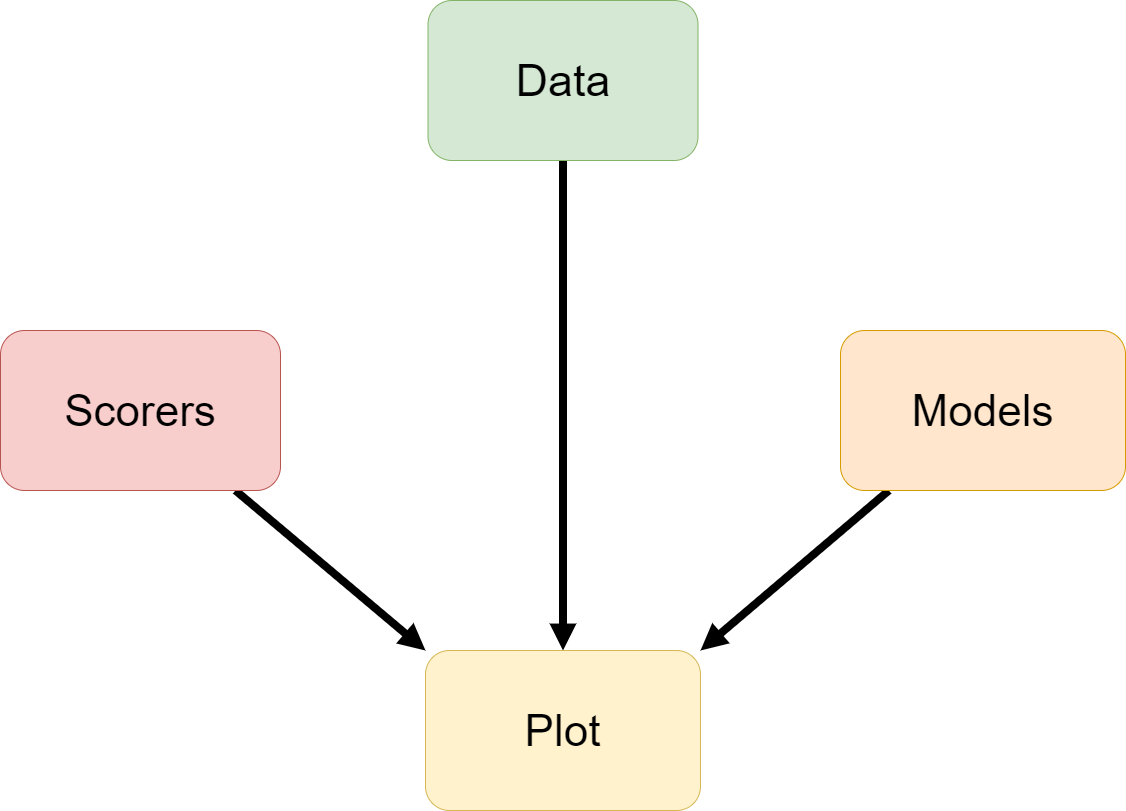

The important note here, is that `Plot` has to inherit attributes from all other three classes. How this is done, and how the classes are constructed is depicted below. This time, the docstrings are directly with the functions.

In [67]:
class Data(object):
    """Class to handle the data"""
    def __init__(self, test_size = 0.2, **kwargs):
        """Instatiates the Data class, using the penguins data from
        seaborn.
        
        Parameters
        ----------
        test_size = float
            Describes the percentage of the test size for the train
            test split        
        """
        data = sns.load_dataset('penguins').dropna().apply(LabelEncoder().fit_transform)
        self.X, self.y = data.iloc[:, :-1], data.iloc[:, -1]
#         self.X, self.y = datasets.load_breast_cancer(return_X_y = True)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = test_size, random_state = 0)
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test = sc.transform(self.X_test)
        # The super() method makes sure, that when this class is inherited, to pass on
        # all not needed keyword arguments (kwargs)
        super().__init__(**kwargs)

        
class Models(object):
    """Class which creates the different models"""
    def __init__(self, C=1.0, kernel='poly', gamma='auto', degree = 3, num_splits = 5, **kwargs):
        """Instantiates the Models class
        
        Parameters
        ----------
        see sklearn SVC and KFold for more information
        """
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.num_splits = num_splits
        self.degree = degree
        super().__init__(**kwargs)
    
    def SVM(self):
        """Instantiates the SVM function
        
        Returns
        -------
        SVC
            The model which can later be used
        """
        try:
            return SVC(C = self.C, kernel = self.kernel, gamma = self.gamma, degree = self.degree)
        except ValueError:
            return SVC(C = self.C, kernel = self.kernel, gamma = "auto", degree = self.degree)
    
    def KFold(self):
        """Instatiates the KFold
        
        Returns
        -------
        KFold
        """
        return KFold(self.num_splits)
        
        
class Scorer(object):
    """Class to create the scorers on the fly"""
    def __init__(self, beta = 0.2, **kwargs):
        self.beta = beta
        self.scorer = make_scorer(self.fbeta, greater_is_better = True)
        super().__init__(**kwargs)
        
    def fbeta(self, y_true, y_pred):
        """Instantiates the fbeta scorer, which can be altered with different
        beta values."""
        return fbeta_score(np.array(y_true), np.array(y_pred), beta = self.beta,
                           pos_label = 0 , average = "binary")

    
class FindBestParameters(Data):
    """Class to find the best parameters for our models from Models class"""
    def __init__(self, **kwargs):
        self._gs_result = None
#         self.param_grid = param_grid
#         self.scoring = scoring
#         self.refit = refit
        super().__init__(**kwargs)
    
    def grid_search(self, scoring, param_grid, cv = 5, estimator = SVC(), refit = "f1"):
        if not self._gs_result:
            print("! WARNING: This process takes some time! Please have patience!")
            self._gs_result = GridSearchCV(estimator = estimator, cv = cv, verbose = 1,
                                           scoring = scoring, param_grid = param_grid,
                                           refit = refit)
        
    def return_best_parameters(self):
        self._gs_result.fit(self.X_train, self.y_train)
        parameters = self._gs_result.cv_results_["params"]
        result = {k : [dic[k] for dic in parameters] for k in parameters[0]}
        for i in scoring.keys():
            result['mean_test_' + i] = self._gs_result.cv_results_['mean_test_' + i]
            result['std_test_' + i] = self._gs_result.cv_results_['std_test_' + i]

        self.results = pd.DataFrame(result)
        self.results.loc[self.results.kernel == 'linear', ['degree', 'gamma']] = np.nan
        self.results.loc[self.results.kernel == 'rbf', 'degree'] = np.nan
        self.results.loc[self.results.kernel == 'sigmoid', 'degree'] = np.nan
        self.results.drop_duplicates(inplace = True)
    
    def find_return_best_parameters(self, **kwargs):
        self.grid_search(**kwargs)
        self.return_best_parameters()
        return self.results
        
    
class Plot(Data, Models, Scorer):
    """Class to create plots, which inherits from Data, Models and Scorer"""
    def __init__(self, **kwargs):
        # The next line initializes the inherited classes
        super().__init__(**kwargs)
    
    def create_validation_curve(self, param_name, title, ylim = [0, 1]):
        """Plot the calculated validation_curve"""
        train_scores, valid_scores = validation_curve(self.SVM(), self.X_train, self.y_train, 
                                                      param_name = param_name, param_range = getattr(self, param_name),
                                                      cv=self.KFold(), scoring = self.scorer)
        plt.plot(getattr(self, param_name), train_scores.mean(axis=1), label = 'Training')
        plt.plot(getattr(self, param_name), valid_scores.mean(axis=1), label = 'Test')
        plt.xlabel(param_name)
        plt.ylabel(f'f{self.beta}')
        plt.ylim(ylim)
        plt.title(title)
        plt.legend()

### Conducting Cross Validation

Cross Validation (CV) is a technique used in machine learning that helps the user determine the best model for the data provided as well as the optimal settings for the hyperparameters of that model. Two common CV functions used through Python’s sklearn library are $\textit{GridSearchCV}$ and $\textit{RandomSearchCV}$. $\textit{GridSearchCV}$ works by looping through the predefined hyperparameters and fits your estimator (model) on your training set, obtaining results for all possible combinations of hyperparameters. While effective, this does impose a substantial computational burden, the scale of which may make $\textit{RandomSearchCV}$ a more appropriate function. Ultimately $\textit{RandomSearchCV}$ works the same as $\textit{GridSearchCV}$, just the number of different hyperparameter combinations it tests is limited by the $\textit{n_iter}$ parameter.

## Kernel Classification Systems
Kernel classification systems refer to the “kernel trick”, whereby a dataset’s dimensionality is increased in order to better classify the data, though this increase in dimensionality is done without having to calculate the specific location (i.e. coordinates) of each data point in the higher dimensional space. The kernel itself is the decision boundary that’s created through the transformation of the data to a higher dimension. 

Support Vector Machines (SVMs) are a type of kernel method that strives to delineate the optimal hyperplane which linearly separates the dataset, where “optimal” refers to where the margin is the greatest. In turn, the “margin” refers to the distance between the two support vectors, which themself represent the two instances in each class that are closest to the decision boundary for the adjacent class. 

### Linear Kernels
A linear kernel is employed when the dataset can be immediately linearly separated, i.e. without first transforming it into a higher dimension. As you might expect, training a Support Vector Machine (SVM) with a linear kernel is completed faster than any other type of kernel. The linear kernel is calculated by taking the dot product of the two support vectors, and it does not have any hyperparameters. 

$\underline{Note}$: We will now proceed to describe, graph, and analyze the results we obtained from the polynomial and rdf kernels.

### SVM Polynomial Kernels - Description
INSERT WRITTEN DESCRIPTION HERE

### SVM Polynomial Kernels - Visualization

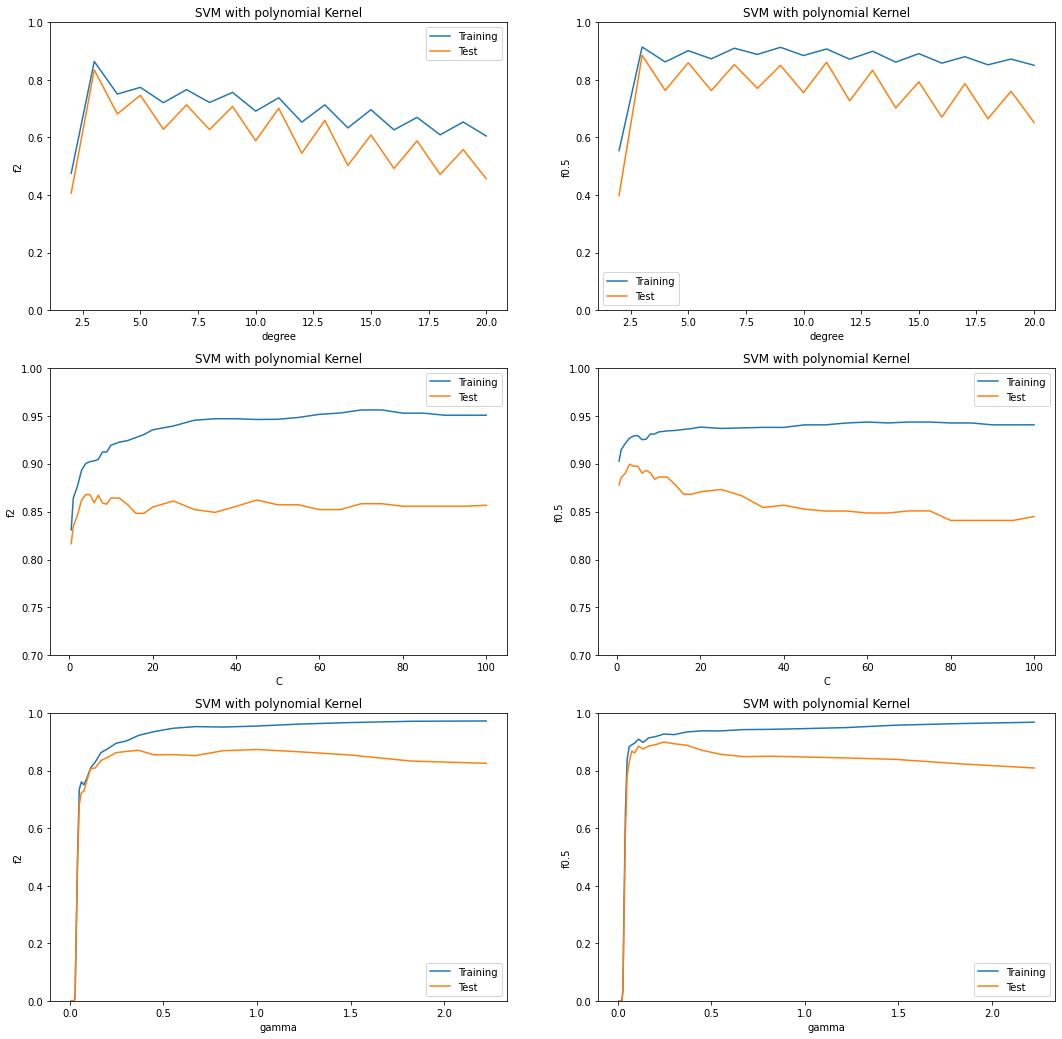

In [35]:
plt_title = "SVM with polynomial Kernel"

plt.figure(figsize = (18, 18))
plt.subplot(3, 2, 1)
Plot(degree = np.arange(2, 21, 1), beta = 2).create_validation_curve("degree", plt_title)
plt.subplot(3, 2, 2)
Plot(degree = np.arange(2, 21, 1), beta = 0.5).create_validation_curve("degree", plt_title)
plt.subplot(3, 2, 3)
Plot(C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = 2).create_validation_curve("C", plt_title, ylim = [0.7, 1])
plt.subplot(3, 2, 4)
Plot(C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = 0.5).create_validation_curve("C", plt_title, ylim = [0.7, 1])
plt.subplot(3, 2, 5)
Plot(gamma = np.exp(np.arange(-5, 1, 0.2)), beta = 2).create_validation_curve("gamma", plt_title)
plt.subplot(3, 2, 6)
Plot(gamma = np.exp(np.arange(-5, 1, 0.2)), beta = 0.5).create_validation_curve("gamma", plt_title)

### SVM Polynomial Kernels - Analysis
INSERT TEXT HERE

### Gaussian Kernels (Radial Base Function) - Description
The $\textbf{Radial Base Function (rdf)}$ is used for general purposes, such as when there is no pre-existing understanding/insight into the distribution of the data. The main hyperparameter in the rdf is gamma, which controls over/underfitting by determining the “reach” of each training instance (low gamma means high reach). In effect, this means that with a large gamma the decision boundary will be more flexed because a small number of instances (close to the decision boundary) are exerting a significant force, which also increases overfitting on that particular set of training data. Sigma has the same effect as gamma (i.e. it impacts over/underfitting), though an increase to sigma reduces overfitting, whereas as described above an increase to gamma does the opposite (and vice versa). 

### Gaussian Kernels (Radial Base Function) - Visualization

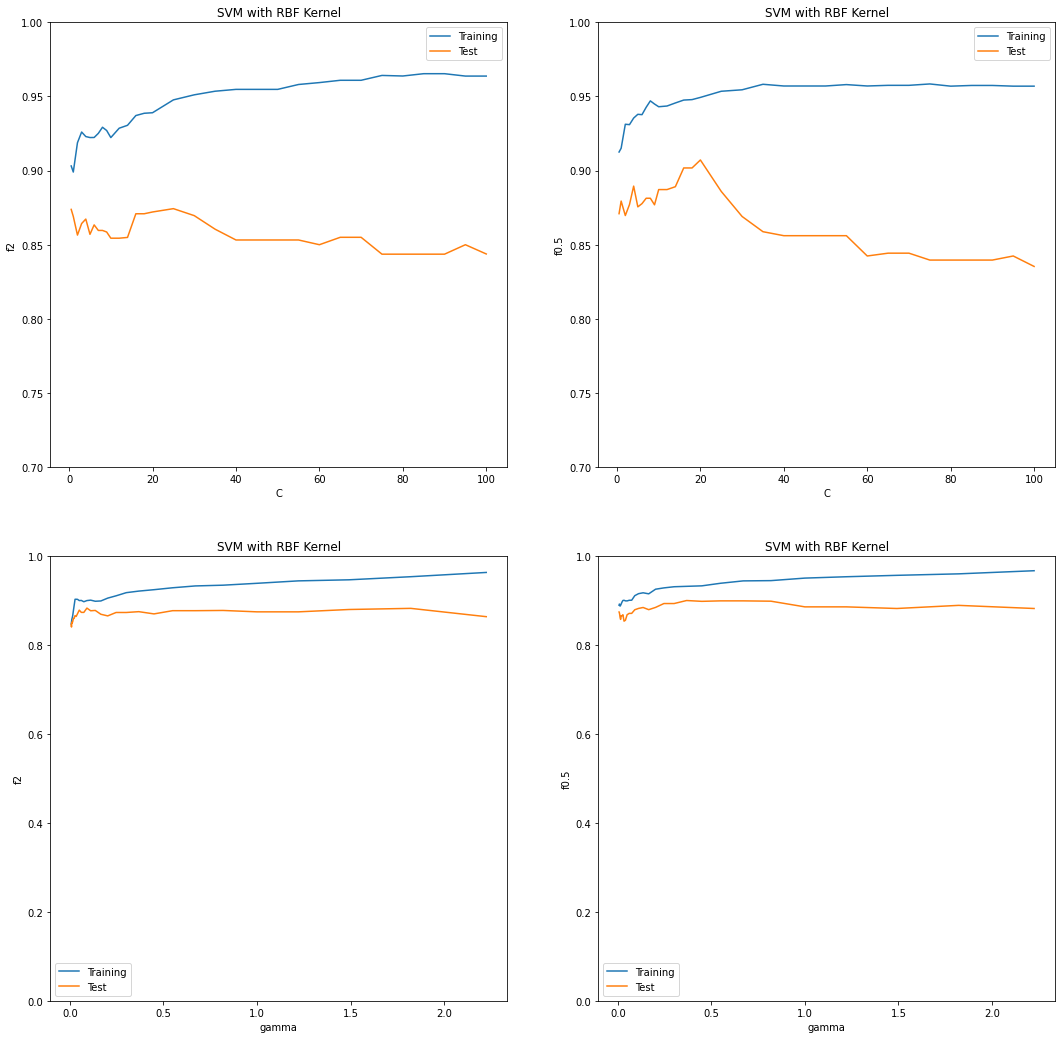

In [36]:
plt_title = "SVM with RBF Kernel"

plt.figure(figsize = (18, 18))
plt.subplot(2, 2, 1)
Plot(kernel = "rbf", C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = 2).create_validation_curve("C", plt_title, ylim = [0.7, 1])
plt.subplot(2, 2, 2)
Plot(kernel = "rbf", C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = 0.5).create_validation_curve("C", plt_title, ylim = [0.7, 1])
plt.subplot(2, 2, 3)
Plot(kernel = "rbf", gamma = np.exp(np.arange(-5, 1, 0.2)), beta = 2).create_validation_curve("gamma", plt_title)
plt.subplot(2, 2, 4)
Plot(kernel = "rbf", gamma = np.exp(np.arange(-5, 1, 0.2)), beta = 0.5).create_validation_curve("gamma", plt_title)

### Gaussian Kernels (Radial Base Function) - Analysis
INSERT TEXT HERE

The general formula for different F-scores are

$F_\beta=(1+\beta^2)\cdot \frac{precision  \cdot  recall}{\beta^2 \cdot precision + recall} = \frac{1+\beta^2}{\frac{1}{precision}+\frac{\beta^2}{recall}}$

When beta = 1, we get F1 score and so on.

F2 indicates that the measure puts more attention on minimizing false negatives than minimizing false positives. F2 shall be chosen if the occurrence of false negatives has higher impact and is intolerable for the use case. E.g in the medical field, while diagnosing a disease, if a healthy person is incorrectly diagnosed as positive then the impact is still tolerable but if a sick person is not diagnosed as positive (false negative) then it can be life-threatening.

In our case, the dataset is balanced and our prediction requirement has equal weightage on the precision and recall hence we have chosen the Accuracy and F1 score as our model performance measure.

# Graph Interpretation #
All the graphs represent that, in general rbf kernel produces better scores than Polynomial kernel. 

## Impact of the hyperparameter degree ##

The degree is only valid for polynomial kernels.  The graphs represent that both the scores decrease as we increase the degree of the polynomial kernel. With degree 3, the model achieves a comparatively better score.

## Impact of the hyperparameter C ##
The SVM model always tries to classify a sample as correct as possible, this may result in decision boundary with a narrow margin, and this will make the model overfit.  To overcome the issue, a soft margin SVM model can be created with wide margin.  However, the wider the margin the higher the chance of a misclassification.  
In the hinge loss function, the parameter C is called the soft margin parameter.  This hyperparameter can also be understood as regularization parameter. C adds a penalty for each misclassified point.  If C is too small, the penalty is small for misclassification and hence a decision boundary with large margin is chosen.  On the other hand, if C is too large the penalty for misclassification is large and hence the model tries to create a decision boundary with small margin.
A point to keep in mind in this regard is that penalty is not same for all misclassified examples. It is directly proportional to the distance to decision boundary.

Both the polynomial and rbf kernel have shown similar trend while tuning the hyperparameter C. With a small value of C, the model achieves low scores.  The higher the value of C, the higher the training scores but the lower the test scores and the model suffers from an overfitting issue.

## Impact of the hyperparameter gamma ##

The hyperparameter gamma is only valid for rbf kernel. It defines how far the influence of a single training example reaches.  If gamma has a low value, the reach is "far" and if the gamma has a high value the reach is "close". The influence on the decision boundary is, with high value of gamma, the nearby datapoints will have more influence and make the decision boundary overfitted and on the other hand with low value of gamma the far points will also contribute and hence the decision boundary will be more linear or smoother.   
The graphs represent the same.  With an increasing value of gamma, the model suffers from overfitting issue.



From here on onwards, we instantiated Data again, in order to only have the data.

Next we will do a gridsearch to search for the optimal parameters.

In [68]:
data = FindBestParameters(test_size = 0.2)

In [69]:
param_grid = {'kernel' : ['poly', 'rbf', 'linear', 'sigmoid'],
              'C' : [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100],
              'gamma' : [1/data.X_train.shape[1], 0.01, 0.1, 1, 10],
              'degree' : [2, 3, 4, 5, 7, 10]}              

scoring = {'Accuracy' : 'accuracy',
           'Precision' : 'precision', 
           'recall' : 'recall',
           'f1' : 'f1'
          }

In [71]:
result = data.find_return_best_parameters(param_grid = param_grid, scoring = scoring)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


In [72]:
result.sort_values('mean_test_f1', ascending = False)

,C,degree,gamma,kernel,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1
725,50.00,NaN,0.010000,rbf,0.902516,0.040953,0.907527,0.052992,0.916010,0.086050,0.907932,0.043029
845,100.00,NaN,0.010000,rbf,0.902586,0.051361,0.912649,0.054104,0.909113,0.098822,0.906602,0.054522
493,1.00,NaN,1.000000,rbf,0.894969,0.053426,0.893814,0.061801,0.915764,0.070971,0.902401,0.050401
609,10.00,NaN,0.100000,rbf,0.891265,0.045652,0.876298,0.039483,0.930296,0.089831,0.899497,0.047322
748,50.00,3.0,0.100000,poly,0.891265,0.052879,0.896114,0.068757,0.908867,0.089103,0.898156,0.051560
...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.01,10.0,0.166667,poly,0.582739,0.031868,0.707647,0.196614,0.705172,0.333263,0.603384,0.124120
259,0.10,NaN,10.000000,sigmoid,0.605451,0.028604,0.662898,0.077321,0.648768,0.277259,0.602445,0.141164
379,0.50,NaN,10.000000,sigmoid,0.571488,0.011604,0.602538,0.031892,0.634236,0.190021,0.597655,0.084587
499,1.00,NaN,10.000000,sigmoid,0.571349,0.015976,0.611884,0.057196,0.627094,0.183406,0.596036,0.075867


In [14]:
result.sort_values('mean_test_Accuracy', ascending = False)

,C,degree,gamma,kernel,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1
845,100.00,NaN,0.010000,rbf,0.902586,0.051361,0.912649,0.054104,0.909113,0.098822,0.906602,0.054522
725,50.00,NaN,0.010000,rbf,0.902516,0.040953,0.907527,0.052992,0.916010,0.086050,0.907932,0.043029
493,1.00,NaN,1.000000,rbf,0.894969,0.053426,0.893814,0.061801,0.915764,0.070971,0.902401,0.050401
842,100.00,NaN,NaN,linear,0.891335,0.055148,0.904180,0.056696,0.894828,0.097549,0.895750,0.057385
722,50.00,NaN,NaN,linear,0.891335,0.055148,0.904180,0.056696,0.894828,0.097549,0.895750,0.057385
...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.10,3.0,0.010000,poly,0.533823,0.007482,0.533823,0.007482,1.000000,0.000000,0.696037,0.006333
488,1.00,2.0,0.100000,poly,0.530049,0.012434,0.532008,0.009444,0.992857,0.014286,0.692766,0.010655
132,0.01,2.0,1.000000,poly,0.530049,0.012434,0.532008,0.009444,0.992857,0.014286,0.692766,0.010655
844,100.00,2.0,0.010000,poly,0.530049,0.012434,0.532008,0.009444,0.992857,0.014286,0.692766,0.010655


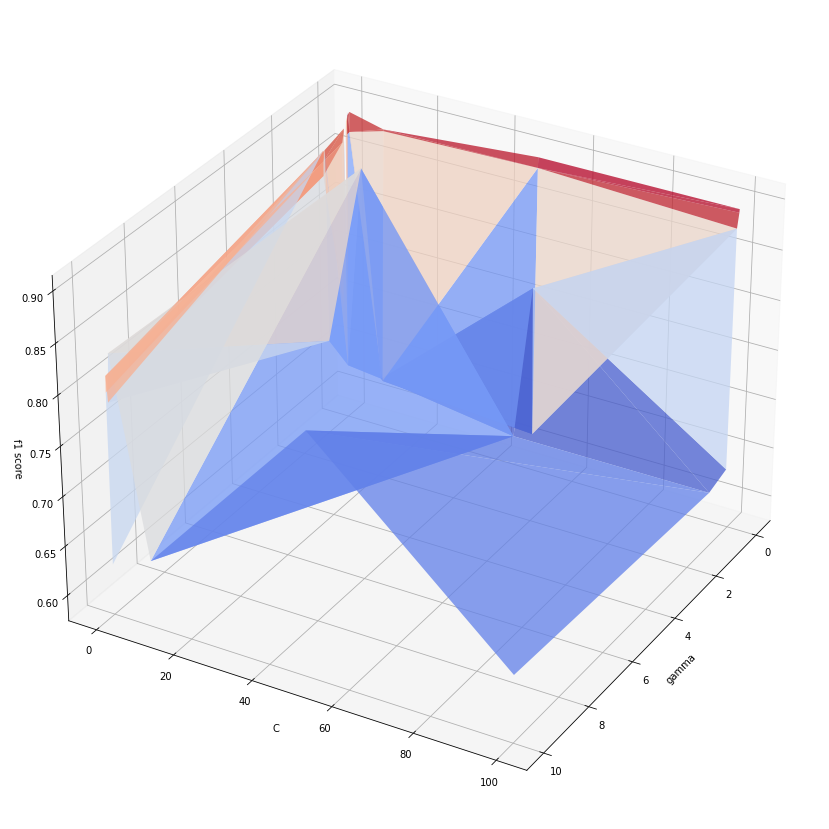

In [23]:
# Plot the surface for f2 score
plt.figure(figsize = (15, 15))
ax = plt.axes(projection='3d')
ax.plot_trisurf(result.gamma, result.fillna(0).C, result.fillna(0).mean_test_f1, 
                cmap = cm.coolwarm, alpha = 0.75)
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_zlabel('f1 score')
ax.view_init(azim=30)    # rotation
plt.show()

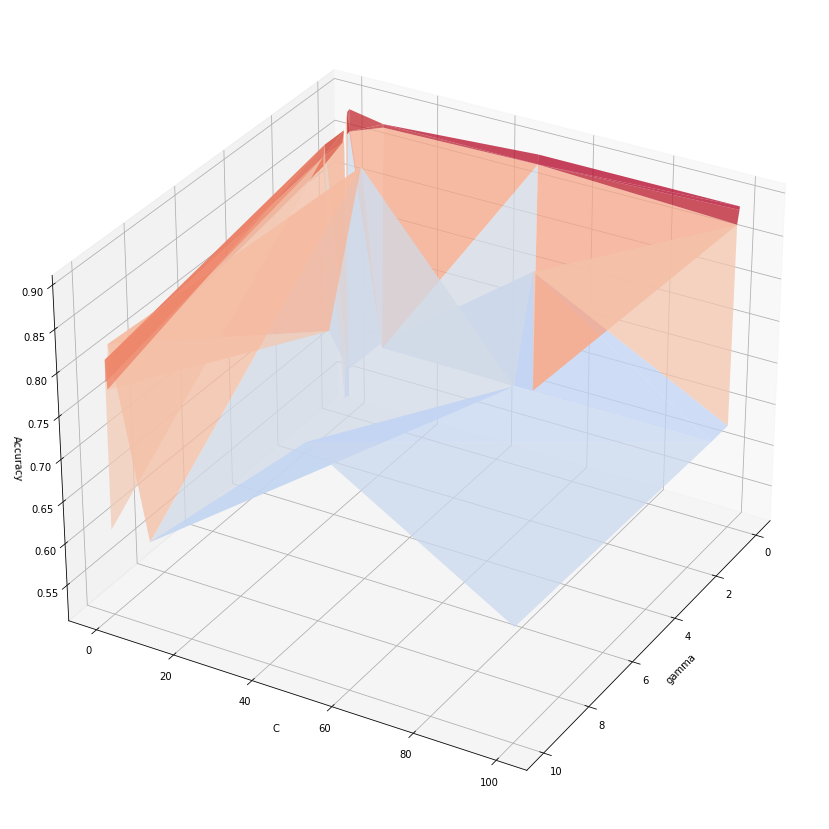

In [24]:
# Plot the surface for f2 score
plt.figure(figsize = (15, 15))
ax = plt.axes(projection='3d')
ax.plot_trisurf(result.fillna(0).gamma, result.fillna(0).C, result.fillna(0).mean_test_Accuracy, 
                cmap = cm.coolwarm, alpha = 0.75)
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_zlabel('Accuracy')
ax.view_init(azim=30)    # rotation
plt.show()

In [31]:
# We use the best one for f2:
# print(results_all_sorted2.loc[0, ['C', 'gamma', 'kernel']])
svm_bestf2 = SVC(C = result.sort_values('mean_test_f1', ascending = False).loc[len(result), 'C'], 
                 gamma = result.sort_values('mean_test_f1', ascending = False).loc[len(result), 'gamma'],
                 kernel = result.sort_values('mean_test_f1', ascending = False).loc[len(result), 'kernel'])
                 #random_state = 0)
svm_bestf2.fit(data.X_train, data.y_train)

y_train_pred = svm_bestf2.predict(data.X_train)
y_test_pred = svm_bestf2.predict(data.X_test)

conf_mat_train = confusion_matrix(data.y_train, y_train_pred)
conf_mat_test = confusion_matrix(data.y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)

Confusion matrix of training sample: 
 [[ 89  35]
 [  9 133]]
Confusion matrix of test sample: 
 [[32  9]
 [ 2 24]]


In [33]:
# We use the best one for f2:
# print(results_all_sorted2.loc[0, ['C', 'gamma', 'kernel']])
svm_bestf2 = SVC(C = result.sort_values('mean_test_f1', ascending = False).loc[0, 'C'], 
                 gamma = result.sort_values('mean_test_f1', ascending = False).loc[0, 'gamma'],
                 kernel = result.sort_values('mean_test_f1', ascending = False).loc[0, 'kernel'])
                 #random_state = 0)
svm_bestf2.fit(data.X_train, data.y_train)

y_train_pred = svm_bestf2.predict(data.X_train)
y_test_pred = svm_bestf2.predict(data.X_test)

conf_mat_train = confusion_matrix(data.y_train, y_train_pred)
conf_mat_test = confusion_matrix(data.y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)

Confusion matrix of training sample: 
 [[  0 124]
 [  0 142]]
Confusion matrix of test sample: 
 [[ 0 41]
 [ 0 26]]


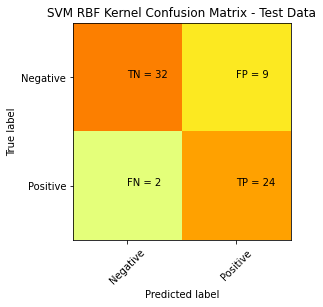

In [32]:
plt.clf()
plt.imshow(conf_mat_test, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('SVM RBF Kernel Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(conf_mat_test[i][j]))
plt.show()

In [22]:
# We use the best one for f0.5:
# print(results_all_sorted05.loc[0, ['C', 'gamma', 'kernel']])
svm_bestf05 = SVC(C = result.sort_values('mean_test_Accuracy', ascending = False).loc[0, 'C'], 
                      gamma = result.sort_values('mean_test_Accuracy', ascending = False).loc[0, "gamma"],
                      kernel = result.sort_values('mean_test_Accuracy', ascending = False).loc[0, 'kernel'],
                      random_state = 0)
svm_bestf05.fit(data.X_train, data.y_train)

y_train_pred = svm_bestf05.predict(data.X_train)
y_test_pred = svm_bestf05.predict(data.X_test)

conf_mat_train = confusion_matrix(data.y_train, y_train_pred)
conf_mat_test = confusion_matrix(data.y_test, y_test_pred)

f05_train = Scorer(beta = 0.5).fbeta(data.y_train, y_train_pred)
f05_test = Scorer(beta = 0.5).fbeta(data.y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f0.5 score of training sample: ', f05_train)
print('f0.5 score of test sample: ', f05_test)

Confusion matrix of training sample: 
 [[  0 124]
 [  0 142]]
Confusion matrix of test sample: 
 [[ 0 41]
 [ 0 26]]
f0.5 score of training sample:  0.0
f0.5 score of test sample:  0.0
